# Pydantic

Pydantic is a powerful Python library used primarily for data validation and settings management using Python type hints.

### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [ ]:
#Graph state
class State(TypedDict):
    topic:str
    tagline:str
    improved_tagline:str
    final_tagline:str 



In [25]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")


llm=ChatOpenAI(model="gpt-4o")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello llms")
result



AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BOk10S2YDli4dxhXfVzxGpWumVCGu', 'finish_reason': 'stop', 'logprobs': None}, id='run-f8dbbdcf-d442-4da5-bc23-e0b31960959d-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
# Nodes
def generate_tagline(state: State):
    """First LLM call to generate initial tagline"""
    msg = llm.invoke(f"Write a catchy tagline for the product: {state['topic']}")
    return {"tagline": msg.content}


def check_tagline_quality(state: State):
    """Gate function to check if the tagline has strong impact"""

    # Simple heuristic - check for presence of action word or emotion
    if any(word in state["tagline"].lower() for word in ["buy", "get", "love", "feel", "now"]):
        return "Pass"
    return "Fail"


def improve_tagline(state: State):
    """Second LLM call to improve tagline with creativity"""

    msg = llm.invoke(f"Make this tagline more creative and appealing: {state['tagline']}")
    return {"improved_tagline": msg.content}


def polish_tagline(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a memorable twist to this tagline: {state['improved_tagline']}")
    return {"final_tagline": msg.content}




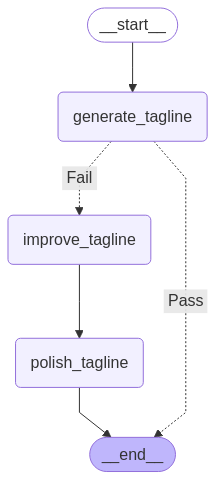

In [34]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_tagline", generate_tagline)
workflow.add_node("improve_tagline", improve_tagline)
workflow.add_node("polish_tagline", polish_tagline)

# Add edges to connect nodes
workflow.add_edge(START, "generate_tagline")
workflow.add_conditional_edges("generate_tagline",check_tagline_quality,{"Fail":"improve_tagline","Pass":END})
workflow.add_edge("improve_tagline", "polish_tagline")
workflow.add_edge("polish_tagline", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [35]:
#invoke
state=chain.invoke({"topic":"Samsung Smart phone"})

In [36]:
state

{'topic': 'Samsung Smart phone',
 'tagline': '"Samsung Smartphone: Unleash the Power of Possibility."',
 'improved_tagline': '"Samsung Smartphones: Ignite Your World of Unlimited Possibilities."',
 'final_tagline': '"Samsung Smartphones: Ignite Your World, Unleash the Universe of Possibilities."'}

In [37]:
state['improved_tagline']

'"Samsung Smartphones: Ignite Your World of Unlimited Possibilities."'

In [38]:
state['final_tagline']

'"Samsung Smartphones: Ignite Your World, Unleash the Universe of Possibilities."'

![image.png](attachment:image.png)

### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

![image.png](attachment:image.png)

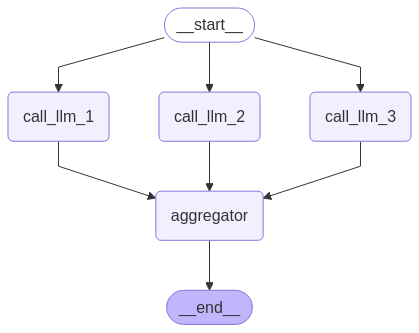

Here's a tagline , use cases,  and marketing about samsung AI smart phone!

tagline:
"Experience the Future in Your Hand: Samsung AI Smartphones - Where Innovation Meets Intelligence."

usecases:
**Use Case 1: Personalized Digital Assistant**

**Name:** Daily Organizer and Personal Assistant

**Primary Actor:** User

**Stakeholders and Interests:**
- **User:** Wants to efficiently manage daily tasks and schedules.
- **Samsung:** Aims to provide a seamless user experience to enhance customer satisfaction and brand loyalty.

**Preconditions:**
- The user has a Samsung AI smartphone with the digital assistant feature enabled.
- User has granted necessary permissions for calendar, contacts, and email access.

**Success Guarantee:**
- The user efficiently manages their daily activities with the help of the AI assistant, saving time and increasing productivity.

**Main Success Scenario:**
1. The user activates the Samsung digital assistant by voice command or designated gesture.
2. The assis

In [39]:
# Graph state
class State(TypedDict):
    topic: str
    tagline: str
    usecases: str
    marketingidea: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial tag_line"""

    msg = llm.invoke(f"Write a tag_line about {state['topic']}")
    return {"tagline": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate use case"""

    msg = llm.invoke(f"Write a use cases about {state['topic']}")
    return {"usecases": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate marketing idea"""

    msg = llm.invoke(f"Write a marketing idea about {state['topic']}")
    return {"marketingidea": msg.content}


def aggregator(state: State):
    """Combine the tagline,use cases and marketing idea into a single output"""

    combined = f"Here's a tagline , use cases,  and marketing about {state['topic']}!\n\n"
    combined += f"tagline:\n{state['tagline']}\n\n"
    combined += f"usecases:\n{state['usecases']}\n\n"
    combined += f"marketingidea:\n{state['marketingidea']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "samsung AI smart phone"})
print(state["combined_output"])

In [40]:
state["tagline"]

'"Experience the Future in Your Hand: Samsung AI Smartphones - Where Innovation Meets Intelligence."'

In [41]:
state["usecases"]

"**Use Case 1: Personalized Digital Assistant**\n\n**Name:** Daily Organizer and Personal Assistant\n\n**Primary Actor:** User\n\n**Stakeholders and Interests:**\n- **User:** Wants to efficiently manage daily tasks and schedules.\n- **Samsung:** Aims to provide a seamless user experience to enhance customer satisfaction and brand loyalty.\n\n**Preconditions:**\n- The user has a Samsung AI smartphone with the digital assistant feature enabled.\n- User has granted necessary permissions for calendar, contacts, and email access.\n\n**Success Guarantee:**\n- The user efficiently manages their daily activities with the help of the AI assistant, saving time and increasing productivity.\n\n**Main Success Scenario:**\n1. The user activates the Samsung digital assistant by voice command or designated gesture.\n2. The assistant greets the user and summarizes the day's agenda, appointments, and tasks.\n3. The user instructs the assistant to add a new meeting to the calendar.\n4. The assistant sugg

In [42]:
state["marketingidea"]

'**Campaign Title: "Galaxy Genius: The Smartphone That Knows You"**\n\n**Objective:**  \nTo highlight the advanced AI capabilities of Samsung\'s latest AI-powered smartphone, positioning it as a truly intelligent companion that understands, predicts, and improves the user experience.\n\n**Target Audience:**  \nTech-savvy millennials, young professionals, and early adopters looking for cutting-edge technology that simplifies and enhances everyday tasks.\n\n**Core Message:**  \n“Experience the Future with the Smartphone That Enhances Your Life.”\n\n**Campaign Elements:**\n\n1. **Interactive Launch Event: "Galaxy Genius Experience Zones"**  \n   Set up interactive zones in major cities where consumers can experience the AI capabilities of the new Samsung smartphone. Each zone targets a specific feature:\n   - **Personal Assistant Zone:** Demonstrations of the phone’s personal assistant predicting user needs and preferences.\n   - **Photography Zone:** Showcasing AI-enhanced camera feature

### Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

![image.png](attachment:image.png)

In [ ]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic


# Augment the LLM with schema for structured output




### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

![image.png](attachment:image.png)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node.

### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

![image.png](attachment:image.png)